# Persian Instrument Classification Notebook

This notebook loads the **PCMiR** dataset of Persian instruments from the specified directory, extracts MFCC features, trains a convolutional neural network and evaluates its performance. A dashboard at the end visualises the confusion matrix and per-class metrics.

In [1]:
from google.colab import files
import zipfile, os

uploaded = files.upload()

zip_name = list(uploaded.keys())[0]

extract_dir = "pcm_dataset"

with zipfile.ZipFile(zip_name, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

print("Done!")
print("Details:")
print(os.listdir(extract_dir))


Saving archive (1).zip to archive (1).zip
Done!
Details:
['Persian Classical Music Instrument Recognition (PCMIR) Database']


In [23]:
# Core libraries
import os
import json
import fnmatch
import numpy as np
import pandas as pd

# Audio processing
import librosa
import librosa.display

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning (TensorFlow / Keras)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)

# Dataset path (already unzipped in Cell 1)
DATASET_DIR = "pcm_dataset/Persian Classical Music Instrument Recognition (PCMIR) Database"

print("Dataset directory set to:", DATASET_DIR)
print("Subfolders:", os.listdir(DATASET_DIR))


Dataset directory set to: pcm_dataset/Persian Classical Music Instrument Recognition (PCMIR) Database
Subfolders: ['Ud', 'ReadMe.txt', 'Santur', 'Ney', 'Tar', 'Setar', 'Kamancheh']


In [25]:
def find_audio_files(directory, extensions=('.wav', '.mp3', '.ogg')):
    for root, dirs, files in os.walk(directory):
        for fname in files:
            if fname.lower().endswith(extensions):
                yield os.path.join(root, fname)

def create_dataset(root_dir):
    data = []
    for f in find_audio_files(root_dir):
        label = os.path.basename(os.path.dirname(f))
        data.append({"file_name": f, "label": label})
    df = pd.DataFrame(data)
    print("Total files:", len(df))
    print("Classes:", df["label"].unique())
    return df


In [26]:
# MFCC feature extraction + simple augmentation

def extract_mfcc(file_name, n_mfcc=40):
    audio, sr = librosa.load(file_name, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)


def augment_audio(audio, sr):
    shifted = librosa.effects.pitch_shift(audio, sr, n_steps=2)
    stretched = librosa.effects.time_stretch(audio, rate=0.9)
    noise = audio + 0.005 * np.random.randn(len(audio))
    return [audio, shifted, stretched, noise]


def extract_features_with_augmentation(file_name, n_mfcc=40, augment=False):
    audio, sr = librosa.load(file_name, sr=None)
    signals = augment_audio(audio, sr) if augment else [audio]
    feats = []
    for sig in signals:
        mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc)
        feats.append(np.mean(mfcc.T, axis=0))
    return np.array(feats)


In [27]:
# Build dataset
dataset = create_dataset(DATASET_DIR)
print("Found", len(dataset), "audio files")

features = []
for f in dataset["file_name"]:
    feats = extract_mfcc(f, n_mfcc=40)
    features.append(feats)

features = np.array(features)
labels = dataset["label"].values

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Total files: 2410
Classes: ['Ud' 'Santur' 'Ney' 'Tar' 'Setar' 'Kamancheh']
Found 2410 audio files
Features shape: (2410, 40)
Labels shape: (2410,)


In [28]:
# Encode labels and split
enc = LabelEncoder()
y = to_categorical(enc.fit_transform(labels))

X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape for CNN input
X_train = X_train[..., np.newaxis, np.newaxis]
X_test = X_test[..., np.newaxis, np.newaxis]

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (1928, 40, 1, 1)
Test: (482, 40, 1, 1)


In [29]:
# CNN model
input_shape = X_train.shape[1:]

model = Sequential([
    Conv2D(32, (3,1), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,1)),
    Dropout(0.3),

    Conv2D(64, (3,1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,1)),
    Dropout(0.3),

    Conv2D(128, (3,1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,1)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 38, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 17, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 1, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,038 (515.77 KB)

 Trainable params: 131,590 (514.02 KB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32
)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.3239 - loss: 2.0475 - val_accuracy: 0.4715 - val_loss: 1.2749
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5327 - loss: 1.2672 - val_accuracy: 0.7332 - val_loss: 0.9521
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6019 - loss: 1.1225 - val_accuracy: 0.7668 - val_loss: 0.7569
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6322 - loss: 0.9747 - val_accuracy: 0.7720 - val_loss: 0.6684
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6806 - loss: 0.8849 - val_accuracy: 0.7824 - val_loss: 0.6028
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6927 - loss: 0.8885 - val_accuracy: 0.8446 - val_loss: 0.5118
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6900 - loss: 0.8477 - val_accuracy: 0.8368 - val_loss: 0.4961
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7067 - loss: 0.8176 - val_accuracy: 0.8394 - 

In [31]:
# Evaluation
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Reports
class_names = enc.classes_
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print(cm)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9029 - loss: 0.3199
Test accuracy: 0.908713698387146
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
              precision    recall  f1-score   support

   Kamancheh       0.91      0.92      0.91        73
         Ney       0.97      0.90      0.93        87
      Santur       0.88      0.84      0.86        88
       Setar       0.96      0.89      0.92        74
         Tar       0.90      0.97      0.93        92
          Ud       0.84      0.94      0.89        68

    accuracy                           0.91       482
   macro avg       0.91      0.91      0.91       482
weighted avg       0.91      0.91      0.91       482

[[67  2  3  0  0  1]
 [ 2 78  2  0  2  3]
 [ 4  0 74  3  4  3]
 [ 0  0  1 66  2  5]
 [ 1  0  2  0 89  0]
 [ 0  0  2  0  2 64]]


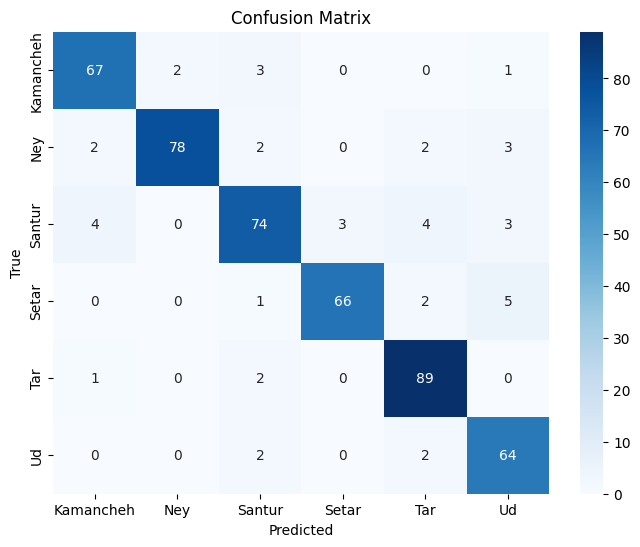

/tmp/ipython-input-2720572083.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




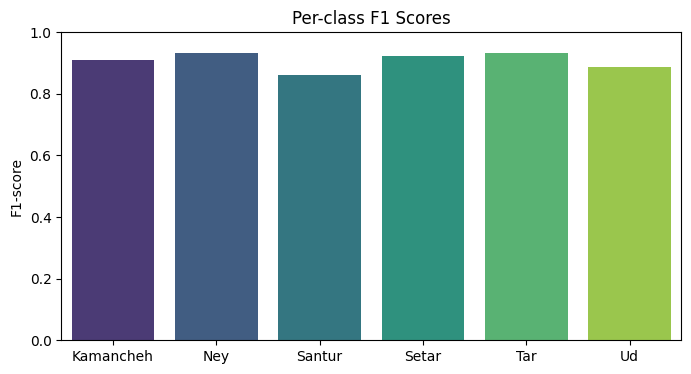

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# F1 scores
f1 = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True))
f1_scores = f1.loc["f1-score", class_names]

plt.figure(figsize=(8,4))
sns.barplot(x=class_names, y=f1_scores, palette="viridis")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.title("Per-class F1 Scores")
plt.show()


In [33]:
import plotly.express as px

# Confusion matrix (interactive)
fig_cm = px.imshow(
    cm,
    x=class_names,
    y=class_names,
    labels={"x": "Predicted", "y": "True", "color": "Count"},
    title="Interactive Confusion Matrix"
)
fig_cm.update_xaxes(side="bottom")
fig_cm.show()

# Per-class metrics (interactive)
f1 = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True))
metrics = f1.loc[["precision", "recall", "f1-score"], class_names].T.reset_index()
metrics = metrics.rename(columns={"index": "class"})

fig_metrics = px.bar(
    metrics,
    x="class",
    y=["precision", "recall", "f1-score"],
    barmode="group",
    title="Per-class Precision, Recall, and F1-score"
)
fig_metrics.update_layout(yaxis_range=[0,1])
fig_metrics.show()
